# Imports

In [1]:
import os
import pickle
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load Data

In [3]:
# Folder containing the datset
data_dir = 'dataset/processed_data'

In [4]:
def load_data(filename, data_dir, data_type):
    h5f = h5py.File(os.path.join(data_dir, filename), 'r')
    data = h5f[data_type][:]
    h5f.close()
    return data

Load training data

In [5]:
train_images = load_data('train_images.h5', data_dir, 'images')

In [6]:
train_categories = load_data('train_categories.h5', data_dir, 'labels')

Load validation data

In [7]:
val_images = load_data('val_images.h5', data_dir, 'images')

In [8]:
val_categories = load_data('val_categories.h5', data_dir, 'labels')

Load test data

In [ ]:
test_images = load_data('test_images.h5', data_dir, 'images')

In [ ]:
test_categories = load_data('test_categories.h5', data_dir, 'labels')

Load mapping

In [9]:
with open('dataset/coco_raw.pickle', 'rb') as file:
    coco_raw = pickle.load(file)
id_category = coco_raw['id_category']

In [10]:
num_classes = len(id_category)
num_classes

80

In [11]:
num_images_train = train_images.shape[0]
num_images_train

19324

### Display a sample image

person
skis


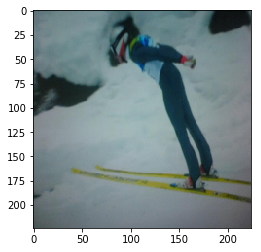

In [12]:
# display image
idx = 10

for category, value in enumerate(train_categories[idx]):
    if value != 0:
        print(id_category[category])

plt.imshow(train_images[idx])
plt.show()

# Define Model

In [13]:
# Download VGG19 model along with the fully-connected layers
model = VGG19(include_top=True, weights='imagenet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [14]:
# Extract the last layer from the last convolutional block
conv_layer = model.get_layer('block5_pool')

In [15]:
conv_layer.output

<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>

In [16]:
# Create model
conv_model = Model(inputs=model.input, outputs=conv_layer.output)

In [17]:
# Start a new Keras Sequential model
image_model = Sequential()

# Add the convolutional part of the VGG19 model
image_model.add(conv_model)

# Flatten the output of the VGG19 model because it is from a
# convolutional layer
image_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG19 model has
# recognized in the image.
image_model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l1(0.01)))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
# image_model.add(Dropout(0.5))

# Add the final layer for the actual classification
image_model.add(Dense(num_classes, activation='sigmoid'))

In [18]:
# Set the VGG19 layers to be non-trainable
conv_model.trainable = False
for layer in conv_model.layers:
    layer.trainable = False

In [19]:
image_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dense_1 (Dense)              (None, 80)                82000     
Total params: 45,797,520
Trainable params: 25,773,136
Non-trainable params: 20,024,384
_________________________________________________________________


In [20]:
# Compile the model
optimizer = Adam(lr=1e-3)

image_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

In [21]:
weights_dir = 'weights'
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

path_checkpoint = os.path.join(weights_dir, 'checkpoint.keras')

# set model callbacks
tb = TensorBoard(log_dir=os.path.join(weights_dir, 'tensorboard-logs'), histogram_freq=0, write_graph=False)
checkpoint = ModelCheckpoint(filepath=path_checkpoint, verbose=1, save_weights_only=True)
# early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

callbacks = [tb, checkpoint]

# Train Model

In [22]:
# Load previously trained model weights
try:
    image_model.load_weights(path_checkpoint)
    print('Checkpoint loaded.')
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
Unable to open file (unable to open file: name = 'weights/checkpoint.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


In [24]:
batch_size = 128

In [23]:
def train_data_generator(x, y, batch_size, shift_fraction=0.2, rotation_range=40, shear_range=0.2):
    train_datagen = ImageDataGenerator(
        rotation_range=rotation_range,
        width_shift_range=shift_fraction,
        height_shift_range=shift_fraction,
        shear_range=shear_range
    )
    generator = train_datagen.flow(x, y, batch_size=batch_size)
    while True:
        x_batch, y_batch = generator.next()
        yield (x_batch, y_batch)

In [ ]:
image_model.fit_generator(
    generator=train_data_generator(train_images, train_categories, batch_size),
    steps_per_epoch=int(num_images_train / batch_size),
    epochs=100,
    validation_data=(val_images, val_categories),
    callbacks=callbacks
)

# Test Model

In [36]:
def get_predictions(image, label, id_category):
    image_batch = np.expand_dims(image, axis=0)
    predictions = image_model.predict(image_batch)
    
    prediction_labels = []
    for index, prediction_probability in enumerate(predictions[0]):
        if prediction_probability > 0.15:
            prediction_labels.append(id_category[index])
    
    true_labels = []
    for index, value in enumerate(label):
        if value == 1:
            true_labels.append(id_category[index])
    
    print('True labels:', true_labels)
    print('Predictions:', prediction_labels)
    
    print('Image:')
    plt.imshow(image)
    plt.show()

In [26]:
idx = 18

True labels: ['person', 'baseball bat', 'baseball glove']
Predictions: ['person', 'sports ball', 'skateboard', 'tennis racket']
Image:


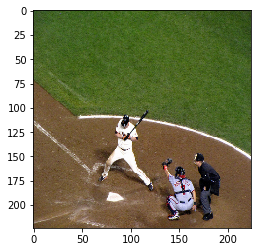

In [37]:
get_predictions(test_images[idx], test_categories[idx], id_category)

True labels: ['person', 'car', 'surfboard']
Predictions: ['person', 'sports ball', 'tennis racket']
Image:


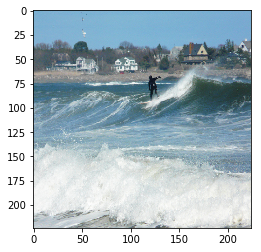

In [38]:
get_predictions(val_images[idx], val_categories[idx], id_category)

True labels: ['person', 'baseball bat', 'baseball glove', 'bottle']
Predictions: ['person', 'sports ball', 'skateboard', 'tennis racket']
Image:


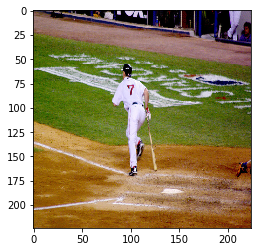

In [39]:
get_predictions(train_images[idx], train_categories[idx], id_category)